# RNA Secondary Structure Prediction Pipelines

This notebook predicts RNA secondary structure using pipelines composed of the
following units:

- Global structure estimator (GSE)
- Local structure refiner (LSR)
- Monomialization unit (MU)
- Binarization unit (BU)
- Symmetrization unit (SU)
- Constraint unit (CU)
- Threshold unit (TU)
- Noise removal unit (NRU)
- Output unit: SU -> CU -> MU -> BU -> NRU (OU)

The last pipeline components are always OU.

In [1]:
import json
from random import sample

import numpy as np
from torch import optim, nn

from diurnal import database, structure, train, transform, visualize, evaluate, segment
from diurnal.models import deep
from diurnal.models.deep import cnn

## Data Preparation

In [2]:
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
SUBDIVISION_SIZE = 32  # Kernel size of the local structure refiner.

database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-10T20:20:50.699610 > INFO Download and install an RNA database.
2024-06-10T20:20:50.728999 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-10T20:20:50.731696 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:00<00:00, 11413.76it/s]


2024-06-10T20:20:51.114229 >     Detected 3975 files. Kept 2326 files.
2024-06-10T20:20:51.117547 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [3]:
def format(dst: str, names: list[str]):
    # Primary structures
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )

format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-10T20:20:51.157037 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-06-10T20:20:51.351407 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-10T20:20:51.353256 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-06-10T20:20:51.403579 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-06-10T20:20:51.405914 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_onehot.npy`.
2024-06-10T20:20:51.434901 >     The file `./data/archiveII_processed_128/validation/primary_onehot.npy` already contains the formatted data.
2024-06-10T20:20:51.434901 > INFO Formatting secondary structures into `./data/archiveII_processed_128/validation/secondary_contact.npy`.
2

In [55]:
def format_data() -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}train/secondary_contact.npy"),
        "mask": np.load(f"{DST}train/primary_masks.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}validation/secondary_contact.npy"),
        "mask": np.load(f"{DST}validation/primary_masks.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


# Create a training set for the LSR.
from os import mkdir
from tqdm import tqdm


def save_global_estimations(model, data, name):
    try:
        mkdir("tmp")
    except:
        pass

    predictions = []
    for i in tqdm(range(len(data["input"][0]))):
        p = model.predict([data["input"][0][i]])
        predictions.append(p)
    np.save(f"tmp/{name}", np.array(predictions))


FIRST = 16  # Select the most important areas.
RANDOM = 8  # Select random areas after the FIRST ones.
STRIDE = 16


def sample_crops(predictions, data, name, maximum, t = 0) -> list:
    predict_crops = []
    pp_crops = []  # Potential pairings
    contact_crops = []
    for index in tqdm(range(len(predictions))):
        prediction = predictions[index] * predictions[index].T * data["mask"][index]
        all_crops = segment.sample_areas(
            prediction, SUBDIVISION_SIZE, stride=STRIDE, threshold=t
        )
        if len(all_crops) > FIRST:
            difference = len(all_crops) - FIRST
            sampling = min(difference, RANDOM)
            if sampling:
                crops = all_crops[:FIRST] + sample(all_crops[FIRST:], sampling)
            else:
                crops = all_crops[:FIRST]
        else:
            crops = all_crops

        for crop, _ in crops:
            predict_crops.append(
                predictions[index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )
            pp_crops.append(
                data["input"][0][index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )
            contact_crops.append(
                data["output"][index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )

        if len(predict_crops) >= maximum:
            break

    np.save(f"tmp/{name}_areas_prediction_{SUBDIVISION_SIZE}.npy", np.array(predict_crops))
    np.save(f"tmp/{name}_areas_pp_{SUBDIVISION_SIZE}.npy", np.array(pp_crops))
    np.save(f"tmp/{name}_areas_contact_{SUBDIVISION_SIZE}.npy", np.array(contact_crops))


def format_refiner_data() -> tuple:
    train_set = {
        "input": (
            np.load(f"tmp/train_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/train_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/train_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    validation_set = {
        "input": (
            np.load(f"tmp/validation_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/validation_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/validation_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    test_set = {
        "input": (
            np.load(f"tmp/test_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/test_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/test_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


def refine(estimation: np.ndarray, potential_pairings: np.ndarray, model) -> np.ndarray:
    result = np.zeros((SIZE, SIZE))
    for v_stride in range(int(SIZE / SUBDIVISION_SIZE)):
        row = v_stride * SUBDIVISION_SIZE
        for h_stride in range(int(SIZE / SUBDIVISION_SIZE)):
            column = h_stride * SUBDIVISION_SIZE
            sub_estimation = estimation[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            sub_input = potential_pairings[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            prediction = model.predict([sub_estimation, sub_input])
            result[row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE] = prediction
    return result

In [33]:
def MU(matrix: np.ndarray) -> np.ndarray:
    return transform.to_monomial_matrix(matrix)


def BU(matrix: np.ndarray) -> np.ndarray:
    return transform.to_binary_matrix(matrix)


def SU(matrix: np.ndarray) -> np.ndarray:
    return matrix * matrix.T


def CU(matrix: np.ndarray, mask: np.ndarray) -> np.ndarray:
    return matrix * mask


def TU(matrix: np.ndarray, threshold: float) -> np.ndarray:
    return (matrix < threshold) * matrix


def NRU(matrix: np.ndarray, threshold: float) -> np.ndarray:
    return segment.convolutional_denoise(matrix, threshold=threshold)


def OU(matrix: np.ndarray, mask: np.ndarray) -> np.ndarray:
    matrix = CU(matrix, mask)
    matrix = SU(matrix)
    matrix = MU(matrix)
    matrix = BU(matrix)
    matrix = NRU(matrix, 2)
    return matrix

In [62]:
def inspect(model, data: dict, i: int) -> None:
    t = data["output"][i]
    p = model(data["input"][0][i], data["mask"][i])
    visualize.compare_pairings(t, p)
    print(f"F1 score: {evaluate.ContactMatrix.f1(t, p)}")


def measure_performances(model, data) -> list[float]:
    scores = []
    for i in range(len(data["output"])):
        t = data["output"][i]
        p = model(data["input"][0][i], data["mask"][i])
        f = evaluate.ContactMatrix.f1(t, p)
        scores.append(f)
    print(f"F1 scores: {scores}")
    print(f"Arithmetic mean: {np.mean(scores)}")
    return scores

## Model 1: Global Estimation (GSE -> OU)

In [7]:
train_data, validation_data, test_data = format_data()

N_MAX_EPOCHS = 100
GSE = deep.NN(
    model=cnn.UNet2D(SIZE, 4),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    use_half=False,
    patience=10,
    verbosity=2,
)
GSE.train(train_data, validation_data)

def model_1(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = OU(x, mask)
    return x

2024-06-10T20:20:57.316434 > INFO Training the model with 1860 data points.
2024-06-10T20:20:57.319942 >     Using 232 data points for validation.
2024-06-10T20:20:57.321986 >     Beginning the training.
2024-06-10T20:21:01.661226 >   0 / 100 [                                                  ] Loss: 2.10887  Patience: 10
2024-06-10T20:21:02.515172 >   1 / 100 [                                                  ] Loss: 2.08082  Patience: 10
2024-06-10T20:21:03.445445 >   2 / 100 [=                                                 ] Loss: 2.07120  Patience: 10
2024-06-10T20:21:04.362385 >   3 / 100 [=                                                 ] Loss: 2.06611  Patience: 10
2024-06-10T20:21:05.329859 >   4 / 100 [==                                                ] Loss: 2.05884  Patience: 10
2024-06-10T20:21:06.299145 >   5 / 100 [==                                                ] Loss: 2.05461  Patience: 10
2024-06-10T20:21:07.586477 >   6 / 100 [===                                 

In [8]:
model_1_results = measure_performances(model_1, test_data)

F1 scores: [0.5499999523162842, 0.8059701323509216, 0.8450704216957092, 0.4375, 0.0, 0.5714285373687744, 0.7692307233810425, 0.27027028799057007, 0.6666666865348816, 0.7605633735656738, 0.6829268336296082, 0.2380952388048172, 0.3888888955116272, 0.8918918967247009, 0.8358209729194641, 0.1304347962141037, 0.6865671277046204, 0.3272727429866791, 0.7111111283302307, 0.7419354319572449, 0.7714285850524902, 0.2857142686843872, 0.25, 0.60317462682724, 0.19354839622974396, 0.7323943376541138, 0.7301587462425232, 0.845070481300354, 0.4848484992980957, 0.5079365372657776, 0.12244898080825806, 0.8571428060531616, 0.3255813717842102, 0.6875, 0.7837838530540466, 0.0, 0.39024391770362854, 0.5454545021057129, 0.7419354915618896, 0.3673469126224518, 0.5671641826629639, 0.3921568691730499, 0.59375, 0.65625, 0.7391303777694702, 0.8115941882133484, 0.19230769574642181, 0.23255813121795654, 0.19607843458652496, 0.4166666567325592, 0.30000001192092896, 0.0, 0.8219177722930908, 0.806451678276062, 0.3913043

## Model 2: Refined Predictions (GSE -> LSR -> OU)

In [69]:
save_global_estimations(GSE, train_data, "train_predictions.npy")
save_global_estimations(GSE, validation_data, "validation_predictions.npy")
save_global_estimations(GSE, test_data, "test_predictions.npy")

print("Sample subregions from the predictions and input data.")
sample_crops(np.load("tmp/train_predictions.npy"), train_data, "train", 30_000)
sample_crops(np.load("tmp/validation_predictions.npy"), validation_data, "validation", 5_000)
sample_crops(np.load("tmp/test_predictions.npy"), test_data, "test", 5_000)

100%|██████████| 232/232 [00:00<00:00, 327.54it/s]


Sample subregions from the predictions and input data.


 91%|█████████ | 210/232 [00:00<00:00, 2404.94it/s]


In [70]:
refiner_train_data, refiner_validation_data, refiner_test_data = format_refiner_data()

N_MAX_EPOCHS =500
LSR = deep.NN(
    model=cnn.UNet2DRefiner(SUBDIVISION_SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    loss_fn_args=None,
    use_half=False,
    patience=10,
    verbosity=2,
    batch=256
)
LSR.train(refiner_train_data, refiner_validation_data)

2024-06-10T21:27:37.491510 > INFO Training the model with 30001 data points.
2024-06-10T21:27:37.494352 >     Using 5022 data points for validation.
2024-06-10T21:27:37.495950 >     Beginning the training.
2024-06-10T21:27:39.056822 >   0 / 500 [                                                  ] Loss: 0.69737  Patience: 10
2024-06-10T21:27:40.147140 >   1 / 500 [                                                  ] Loss: 0.65701  Patience: 10
2024-06-10T21:27:41.230840 >   2 / 500 [                                                  ] Loss: 0.64766  Patience: 10
2024-06-10T21:27:42.336840 >   3 / 500 [                                                  ] Loss: 0.64315  Patience: 10
2024-06-10T21:27:43.422916 >   4 / 500 [                                                  ] Loss: 0.63924  Patience: 10
2024-06-10T21:27:44.672627 >   5 / 500 [                                                  ] Loss: 0.63635  Patience: 10
2024-06-10T21:27:45.897975 >   6 / 500 [                                  

In [71]:
def model_2(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x *= refine(x, pp, LSR)
    x = OU(x, mask)
    return x
# 0.231

model_2_results = measure_performances(model_2, test_data)

F1 scores: [0.3137255012989044, 0.472222238779068, 0.5217391848564148, 0.4117647111415863, 0.2962963283061981, 0.31111112236976624, 0.4888888895511627, 0.42553192377090454, 0.3999999761581421, 0.5070423483848572, 0.5, 0.24390242993831635, 0.30434781312942505, 0.6052631139755249, 0.5142857432365417, 0.1818181872367859, 0.6571428775787354, 0.23188406229019165, 0.40816324949264526, 0.5151515007019043, 0.4637681245803833, 0.0833333358168602, 0.17543859779834747, 0.3529411554336548, 0.1515151560306549, 0.4266666769981384, 0.4057970941066742, 0.4285714328289032, 0.25, 0.2432432472705841, 0.22580644488334656, 0.5070422291755676, 0.3265306353569031, 0.37142857909202576, 0.5454545617103577, 0.08000000566244125, 0.47058823704719543, 0.40000003576278687, 0.5882353186607361, 0.28125, 0.5641025900840759, 0.1846153885126114, 0.28169018030166626, 0.4637681245803833, 0.6274510025978088, 0.4927535951137543, 0.0923076942563057, 0.238095223903656, 0.3571428656578064, 0.3606557548046112, 0.393939375877380

## Model 3: Refined Predictions (GSE -> [CU -> NRU] -> LSR -> OU)

In [43]:
class Estimator:
    def predict(pp) -> np.ndarray:
        estimation = GSE.predict(pp)
        mask = pp[0].copy()
        mask[mask > 0] = 1
        estimation *= mask
        return NRU(estimation, 2)


save_global_estimations(Estimator, train_data, "train_predictions.npy")
save_global_estimations(Estimator, validation_data, "validation_predictions.npy")
save_global_estimations(Estimator, test_data, "test_predictions.npy")

print("Sample subregions from the predictions and input data.")
sample_crops(np.load("tmp/train_predictions.npy"), train_data, "train", 30_000)
sample_crops(np.load("tmp/validation_predictions.npy"), validation_data, "validation", 5_000)
sample_crops(np.load("tmp/test_predictions.npy"), test_data, "test", 5_000)

100%|██████████| 232/232 [00:00<00:00, 335.64it/s]


Sample subregions from the predictions and input data.


 91%|█████████▏| 212/232 [00:00<00:00, 3461.95it/s]


In [44]:
refiner_train_data, refiner_validation_data, refiner_test_data = format_refiner_data()

N_MAX_EPOCHS = 500
LSR = deep.NN(
    model=cnn.UNet2DRefiner(SUBDIVISION_SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    loss_fn_args=None,
    use_half=False,
    patience=10,
    verbosity=2,
    batch=256
)
LSR.train(refiner_train_data, refiner_validation_data)

2024-06-10T20:56:39.713781 > INFO Training the model with 30022 data points.
2024-06-10T20:56:39.714110 >     Using 5004 data points for validation.
2024-06-10T20:56:39.716347 >     Beginning the training.
2024-06-10T20:56:41.375109 >   0 / 500 [                                                  ] Loss: 0.51955  Patience: 10
2024-06-10T20:56:42.461277 >   1 / 500 [                                                  ] Loss: 0.51816  Patience: 10
2024-06-10T20:56:43.601265 >   2 / 500 [                                                  ] Loss: 0.51698  Patience: 10
2024-06-10T20:56:44.827023 >   3 / 500 [                                                  ] Loss: 0.51585  Patience: 10
2024-06-10T20:56:45.991174 >   4 / 500 [                                                  ] Loss: 0.51440  Patience: 10
2024-06-10T20:56:47.240262 >   5 / 500 [                                                  ] Loss: 0.51262  Patience: 10
2024-06-10T20:56:48.350231 >   6 / 500 [                                  

In [45]:
def model_3(pp: np.ndarray, mask: np.ndarray):
    x = Estimator.predict([pp])
    x = refine(x, pp, LSR)
    x = OU(x, mask)
    return x


model_3_results = measure_performances(model_3, test_data)

F1 scores: [0.0, 0.111111119389534, 0.14084509015083313, 0.1355932205915451, 0.0, 0.0, 0.20000001788139343, 0.5909091234207153, 0.6060606241226196, 0.0, 0.27906978130340576, 0.1428571343421936, 0.30434781312942505, 0.2153846174478531, 0.1818181872367859, 0.072727270424366, 0.13333332538604736, 0.06666667014360428, 0.39024391770362854, 0.20689654350280762, 0.06666667014360428, 0.1666666716337204, 0.12244898080825806, 0.0, 0.06557376682758331, 0.17241378128528595, 0.03225806728005409, 0.131147563457489, 0.0, 0.2352941334247589, 0.0, 0.0, 0.1818181872367859, 0.09677419811487198, 0.125, 0.0, 0.2380952388048172, 0.0, 0.0, 0.06451612710952759, 0.1269841194152832, 0.07017543911933899, 0.0, 0.1846153885126114, 0.19999998807907104, 0.13333334028720856, 0.06451613456010818, 0.23255813121795654, 0.18867924809455872, 0.3076923191547394, 0.1090909093618393, 0.0, 0.030303029343485832, 0.033898305147886276, 0.13333332538604736, 0.25806450843811035, 0.13114753365516663, 0.20000000298023224, 0.24657535

## Model 4: Refined Predictions (GSE -> OU -> LSR -> OU)

In [56]:
class Estimator:
    def predict(pp) -> np.ndarray:
        estimation = GSE.predict(pp)
        mask = pp[0].copy()
        mask[mask > 0] = 1
        return OU(estimation, mask)


save_global_estimations(Estimator, train_data, "train_predictions.npy")
save_global_estimations(Estimator, validation_data, "validation_predictions.npy")
save_global_estimations(Estimator, test_data, "test_predictions.npy")

print("Sample subregions from the predictions and input data.")
sample_crops(np.load("tmp/train_predictions.npy"), train_data, "train", 30_000, -0.01)
sample_crops(np.load("tmp/validation_predictions.npy"), validation_data, "validation", 5_000, -0.01)
sample_crops(np.load("tmp/test_predictions.npy"), test_data, "test", 5_000, -0.01)

100%|██████████| 232/232 [00:00<00:00, 246.07it/s]


Sample subregions from the predictions and input data.


 90%|████████▉ | 208/232 [00:00<00:00, 3745.70it/s]


In [57]:
refiner_train_data, refiner_validation_data, refiner_test_data = format_refiner_data()

N_MAX_EPOCHS = 500
LSR = deep.NN(
    model=cnn.UNet2DRefiner(SUBDIVISION_SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    use_half=False,
    patience=10,
    verbosity=2,
    batch=256
)
LSR.train(refiner_train_data, refiner_validation_data)

2024-06-10T21:09:59.475185 > INFO Training the model with 30000 data points.
2024-06-10T21:09:59.475185 >     Using 5016 data points for validation.
2024-06-10T21:09:59.480168 >     Beginning the training.
2024-06-10T21:10:01.311241 >   0 / 500 [                                                  ] Loss: 0.72161  Patience: 10
2024-06-10T21:10:02.383482 >   1 / 500 [                                                  ] Loss: 0.69501  Patience: 10
2024-06-10T21:10:03.428783 >   2 / 500 [                                                  ] Loss: 0.67284  Patience: 10
2024-06-10T21:10:04.480238 >   3 / 500 [                                                  ] Loss: 0.66679  Patience: 10
2024-06-10T21:10:05.511052 >   4 / 500 [                                                  ] Loss: 0.66145  Patience: 10
2024-06-10T21:10:06.513965 >   5 / 500 [                                                  ] Loss: 0.65719  Patience: 10
2024-06-10T21:10:07.542010 >   6 / 500 [                                  

In [68]:
def model_4(pp: np.ndarray, mask: np.ndarray):
    x = Estimator.predict([pp])
    y = refine(x, pp, LSR)
    x *= y
    x = OU(x, mask)
    return x


model_4_results = measure_performances(model_4, test_data)

F1 scores: [0.5306122303009033, 0.7567567825317383, 0.7894736528396606, 0.37837839126586914, 0.0, 0.4000000059604645, 0.695652186870575, 0.3265306055545807, 0.476190447807312, 0.7297297120094299, 0.5833333134651184, 0.29787230491638184, 0.3913043737411499, 0.824999988079071, 0.7777777910232544, 0.14035087823867798, 0.6666666865348816, 0.39436620473861694, 0.6956521272659302, 0.6849315166473389, 0.746666669845581, 0.20000000298023224, 0.2545454502105713, 0.5135135054588318, 0.2432432472705841, 0.7435897588729858, 0.7027027010917664, 0.8219177722930908, 0.3749999701976776, 0.5070422887802124, 0.1875, 0.7792208194732666, 0.31111112236976624, 0.637681245803833, 0.7407407164573669, 0.0, 0.4583333432674408, 0.5066667199134827, 0.6756756901741028, 0.35483869910240173, 0.5526316165924072, 0.37681159377098083, 0.5675675868988037, 0.6197183132171631, 0.7199999094009399, 0.7179486751556396, 0.21212120354175568, 0.2916666269302368, 0.26865673065185547, 0.4262295365333557, 0.3188406229019165, 0.0, 

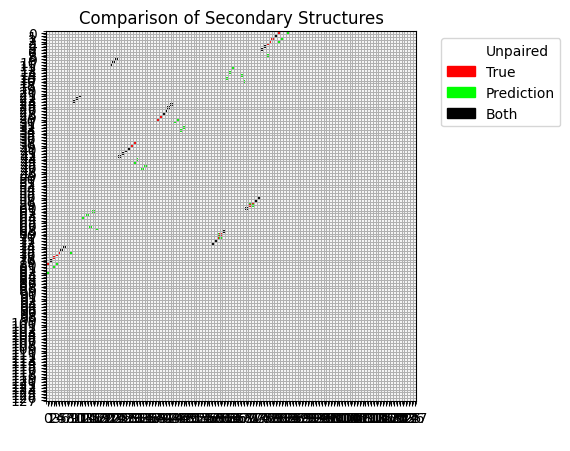

F1 score: 0.5306122303009033


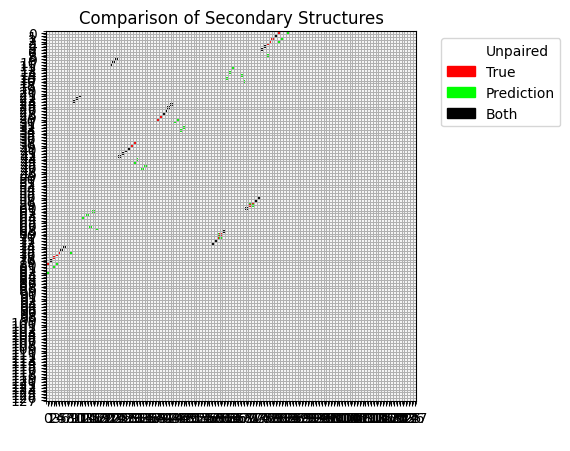

F1 score: 0.5306122303009033


In [66]:
inspect(model_4, test_data, 0)
inspect(model_1, test_data, 0)